In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
from flopy.utils.triangle import Triangle as Triangle
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob

sys.path.insert(1, '../test_premier_model/')
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss_uns import *

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "Modele_raffine"
exe_name= "../../exe/mf6"

In [3]:
def make_plot(grid,nodenumber):
    
    """
    make a plot given a list of nodenumber
    grid : a modflow grid with flopy.discretization package
    nodenumber : list, the list containing the nodenumbers to plot
    
    """
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    pmv = fp.plot.PlotMapView(modelgrid=grid)
    pmv.plot_grid(ax=ax)
    
    o = 0
    for cellid in nodenumber:
        o +=1
        ax.scatter(grid.xcellcenters[cellid], grid.ycellcenters[cellid])

In [4]:
def make_plot_ar(grid,array):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    pmv = fp.plot.PlotMapView(modelgrid=grid)
    pmv.plot_grid(ax=ax,lw=0.35)
    pmv.plot_array(array)

In [5]:
# some paths

R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../../data/txt_couches_nouv/s1_mnt.txt"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"
sea_path = "../../data/shp/Sea_BC_L93.shp"
rivers = [Agly_path,Tet_path,Rea_path,Tech_path,Bol_path,Cant_path,sea_path]

Agly_stations = "../../data/Fleuves/stations_agly.csv"
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"

In [6]:
#spatial parameters

# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = 660e3,615e4,710.3e3,620.5e4

Lx = x1-x0
Ly = y1-y0
nlay = 1
delc = delr = 1000
ncol = int(Lx/delr)
nrow = int(Ly/delc)
top = 50
botm = -50

In [7]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='refine_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)

# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname="model_name",
                           model_nam_file='{}.nam'.format(model_name))

dis = fp.mf6.ModflowGwfdis(gwf,nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0)

In [8]:
# create a gridgen object
g = Gridgen(dis, model_ws=model_dir,exe_name="../../exe/Gridgen.exe")

In [9]:
# define domain
R = gp.read_file(R_path)

# remove inactive cells --> some issues with the plot
g.add_active_domain(gp2lst(R),range(nlay)) 

In [10]:
# define refined zones
for riv in rivers:
    gpRiv = gp.read_file(riv)
    g.add_refinement_features(gp2lst(gpRiv,"line"),"line",2,range(1)) # gp2lst transform a gp object in a list that can be used in Gridgen

In [11]:
g.build()

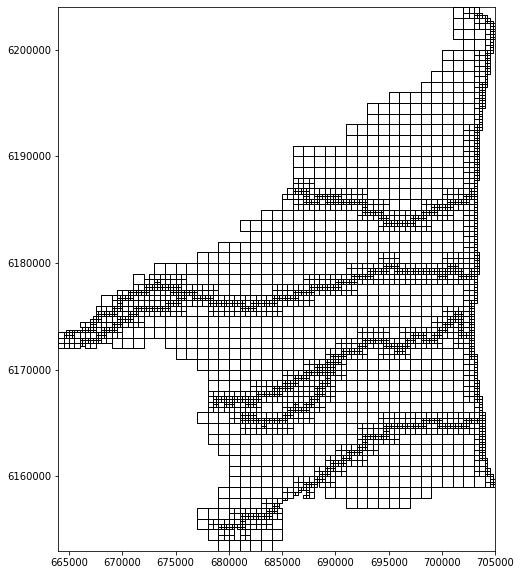

In [12]:
# Check if the refining has been done 
fig,ax=plt.subplots(figsize=(10,10))
ax.set(aspect="equal")
g.plot()

In [13]:
#retrieve infos about the grid and for the disv
grid = gridgen2grid(g)

In [14]:
# top
MNT = Raster.load(MNT_path)

top = MNT.resample_to_grid(np.array(grid.xcellcenters), # xc and yc must be an array (idk why...)
                           np.array(grid.ycellcenters),
                           band = MNT.bands[0],
                           method="nearest")
top[top<-1000]=50

In [15]:
# bot

folder_path = "../../data/txt_couches_nouv"
surfaces = []
for file in glob.glob(os.path.join(folder_path, '*.txt')):
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(np.array(grid.xcellcenters),
                                          np.array(grid.ycellcenters),
                                          band = Rast.bands[0],
                                          method="nearest"))
Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]
BOT = PMS.copy()
BOT[PMS==-9999] = PC[PMS==-9999]
BOT[PC==-9999] = Q[PC==-9999]
BOT[BOT==-9999] = top[BOT==-9999] - 50

BOT[(top-BOT)<=10] = top[(top-BOT)<=10] - 10 # minimum of 10 m thickness to avoid bug and numerical issues

In [16]:
#recharge
path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch_disv(path,grid)

In [17]:
# import props
dic_disv=g.get_gridprops_disv()
nlay = dic_disv["nlay"]
ncpl = dic_disv["ncpl"]
vertices = dic_disv["vertices"]
cell2d = dic_disv["cell2d"]
nvert = dic_disv["nvert"]

cell2dF = pd.DataFrame(cell2d) # use of a df of cell2d to speed the code during import (indexing, coordinates,...)

In [18]:
#domain
domain_path = "../../../data/shp/limiteModeleRoussillon_poly" # path from working folder
inters = g.intersect(domain_path,"polygon",0)
lst_domain = inters.nodenumber
idomain = np.zeros(ncpl)
idomain[lst_domain]=1

In [19]:
# add some BCs

Bcsea_path = "../../../data/shp/Sea_BC_L93" # path
inter = g.intersect(Bcsea_path,"line",0) #intersect 

#create stress package
sea_chd=[];lst_chd=[] 
for cellid in inter.nodenumber:
    if (cellid not in lst_chd) | (cellid not in lst_domain):
        lst_chd.append(cellid)
        sea_chd.append(((0,cellid),0))

C:\Users\emmal\Anaconda3\lib\site-packages\flopy\utils\gridgen.py:1552: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  usecols=tuple(range(ncol)))


In [20]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)

name_et = ["étang de canet","étang de leucate"]

et_chd_lst=[]
for i in name_et:
    coord_et = []
    etang = Bcet.loc[Bcet.TOPONYME==i]
    for x,y in zip(etang.geometry.values[0].exterior.xy[0],etang.geometry.values[0].exterior.xy[1]):
        coord_et.append((x,y))

    res = g.intersect([[coord_et]],"polygon",0)
    etangs_chd = res.nodenumber
    CHD = 0; 
    for x in etangs_chd:
        if (x in lst_domain) & (x not in lst_chd):
            et_chd_lst.append(((0,x),CHD))
            lst_chd.append(x)

In [21]:
agy_chd = add_river_disv(Agly_path,Agly_stations,g,28,0.1,lst_chd,lst_domain,grid,cell2dF,layer=0)

In [22]:
tet_chd = add_river_disv(Tet_path,Tet_stations,g,180,0.1,lst_chd,lst_domain,grid,cell2dF,layer=0)

In [23]:
Bol_chd = add_river_disv(Bol_path,Bol_stations,g,180,90,lst_chd,lst_domain,grid,cell2dF,layer=0)

In [24]:
Rea_chd = add_river_disv(Rea_path,Rea_stations,g,180,0.1,lst_chd,lst_domain,grid,cell2dF,layer=0)

In [25]:
Cant_chd = add_river_disv(Cant_path,Cant_stations,g,135,40,lst_chd,lst_domain,grid,cell2dF,layer=0)

In [26]:
Tech_chd = add_river_disv(Tech_path,Tech_stations,g,180,0.1,lst_chd,lst_domain,grid,cell2dF,layer=0)

In [27]:
# basic modules

sim = fp.mf6.MFSimulation(sim_name='first2D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)

gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

disv = fp.mf6.ModflowGwfdisv(gwf,xorigin=x0,yorigin=y0,nlay=nlay,
                             ncpl=ncpl,cell2d=cell2d,vertices=vertices,
                             nvert=nvert,top = top,botm=BOT,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="moderate")


# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf)


# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])

# nodeflowproperty
kh = 5e-5
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True,xt3doptions=[True])

# recharge

rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400)
   
    
# constant heads packages

chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(sea_chd), 
                                              stress_period_data={0: sea_chd}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

Agly = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(agy_chd), 
                                              stress_period_data={0: agy_chd}, save_flows=True)

Tet = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='tet', filename="tet.chd", maxbound=len(tet_chd), 
                                              stress_period_data={0: tet_chd}, save_flows=True)

Bol = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                              stress_period_data={0: Bol_chd}, save_flows=True)

Cant = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                              stress_period_data={0: Cant_chd}, save_flows=True)

Rea = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                              stress_period_data={0: Rea_chd}, save_flows=True)

Tech = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                              stress_period_data={0: Tech_chd}, save_flows=True)

In [28]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model Modele_raffine...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package bol...
    writing package cant...
    writing package rea...
    writing package tech...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
re

(True, [])

In [29]:
head = get_heads(model_name,model_dir)

bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

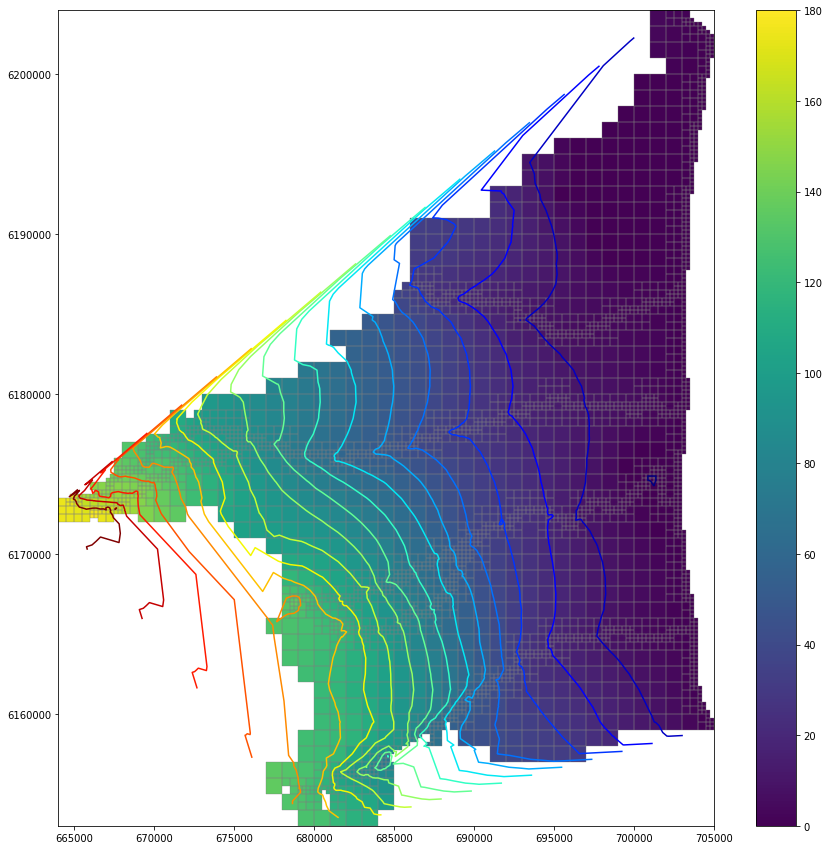

In [30]:
fig = plt.figure(figsize=(15,15))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=0)
ml.plot_grid(lw=0.35)

hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
hmesh.set_clim(0,180)
cont=ml.contour_array(head,masked_values=[1e30],levels=np.linspace(0,170,18),cmap="jet")
plt.colorbar(hmesh)